In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hockeysuite as hs
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from tqdm import tqdm
import joblib

In [2]:
forest = joblib.load('fearfactorxg.joblib')
importances = forest.feature_importances_

def xG(s, xC, yC, p, sinp, ssle, z, st, pe, pxC, pyC):
    return forest.predict(np.array((s, xC, yC, p, sinp, ssle, z, st, pe, pxC, pyC)).reshape(1, -1))

In [3]:
print(importances)

[0.02471855 0.12168486 0.11335357 0.04053626 0.19949815 0.14573501
 0.00539187 0.03589211 0.04657377 0.13892594 0.1276899 ]


In [4]:
pbp21 = pd.read_csv('nhl_pbp_20212022.csv')
# toi20 = pd.read_csv('nhl_shifts_20202021.csv')
pbp20 = pd.read_csv('nhl_pbp_20202021.csv')
# toi19 = pd.read_csv('nhl_shifts_20192020.csv')
pbp19 = pd.read_csv('nhl_pbp_20192020.csv')
# toi18 = pd.read_csv('nhl_shifts_20182019.csv')
pbp18 = pd.read_csv('nhl_pbp_20182019.csv')
# toi17 = pd.read_csv('nhl_shifts_20172018.csv')
pbp17 = pd.read_csv('nhl_pbp_20172018.csv')

In [5]:
pbp20['Game_Id'] = pbp20['Game_Id'] - 2000
pbp19['Game_Id'] = pbp19['Game_Id'] - 4000
pbp18['Game_Id'] = pbp18['Game_Id'] - 6000
pbp17['Game_Id'] = pbp17['Game_Id'] - 8000

In [6]:
# toi_table = toi20.append(toi19).append(toi18).append(toi17)
pbp_table = pbp21.append(pbp20).append(pbp19).append(pbp18)#.append(pbp17)

In [7]:
gids = list(set(pbp_table['Game_Id']))

In [8]:
def fo_parser(desc):
    
    winner, players = desc.split(' - ')
    zone = winner.split(' ')[2][:3]
    winner = winner[:3]
    player1, player2 = players.split(' vs ')
    team1 = player1[:3]
    team2 = player2[:3]
    
    if team1 == winner:
        winning_player = player1.split(' ')[-1]
        winning_team = team1
        losing_player = player2.split(' ')[-1]
        losing_team = team2
    elif team2 == winner:
        winning_player = player2.split(' ')[-1]
        winning_team = team2
        losing_player = player1.split(' ')[-1]
        losing_team = team1
        
    return zone, winning_player, winning_team, losing_player, losing_team

In [9]:
dates = list(set(pbp_table['Date']))

# For reading in stats

In [19]:
r = pd.read_csv('full_stats.csv')

### advantage v2:

* xG (includes shots, goals, missed shots)
* blocked shots for (still deliberating...)
* faceoff % (puck possession)
* penalty minutes drawn (clever play/building in strength)
* gives against (puck possession)
* takeaways for (puck possession)

getting rid of:

* save % - goalie factor removed to purely analyse skaters. covered by xG anyway
* separating out shots on goal and missed shots - folding it all into xG

In [20]:
home = r['Home team']
away = r['Away team']
blocked_for_home = r['Blocked for home']
blocked_for_away = r['Blocked for away']
xG_for_home = r['xG for home']
xG_for_away = r['xG for away']
# missed_for_home = r['Missed for home']
# missed_for_away = r['Missed for away']
# sog_for_home = r['SOG for home']
# sog_for_away = r['SOG for away']
goals_for_home = r['Goals for home']
goals_for_away = r['Goals for away']
f_home = r['FOW% home']
f_away = r['FOW% away']
pmins_drawn_home = r['Penalty minutes drawn home']
pmins_drawn_away = r['Penalty minutes drawn away']
gives_against_home = r['Gives against home']
gives_against_away = r['Gives against away']
takes_for_home = r['Takeaways for home']
takes_for_away = r['Takeaways for away']
# save_pct_home = r['SV% home']
# save_pct_away = r['SV% away']

In [21]:
bf_home = blocked_for_home / (blocked_for_home + blocked_for_away)
bf_away = blocked_for_away / (blocked_for_home + blocked_for_away)
xf_home = xG_for_home / (xG_for_home + xG_for_away)
xf_away = xG_for_away / (xG_for_home + xG_for_away)
# mf_home = missed_for_home / (missed_for_home + missed_for_away)
# mf_away = missed_for_away / (missed_for_home + missed_for_away)
# sf_home = sog_for_home / (sog_for_home + sog_for_away)
# sf_away = sog_for_away / (sog_for_home + sog_for_away)
gf_home = goals_for_home / (goals_for_home + goals_for_away)
gf_away = goals_for_away / (goals_for_home + goals_for_away)
fp_home = f_home / (f_home + f_away)
fp_away = f_away / (f_home + f_away)
pd_home = pmins_drawn_home / (pmins_drawn_home + pmins_drawn_away)
pd_away = pmins_drawn_away / (pmins_drawn_home + pmins_drawn_away)
ga_home = gives_against_home / (gives_against_home + gives_against_away)
ga_away = gives_against_away / (gives_against_home + gives_against_away)
tf_home = takes_for_home / (takes_for_home + takes_for_away)
tf_away = takes_for_away / (takes_for_home + takes_for_away)
# saves_home = sog_for_away - goals_for_away
# saves_away = sog_for_home - goals_for_home
# sp_home = saves_home / (saves_home + saves_away)
# sp_away = saves_away / (saves_home + saves_away)

In [22]:
wins_home = np.zeros(len(gf_home))
wins_away = np.zeros(len(gf_home))

for i, (g1, g2) in enumerate(zip(gf_home, gf_away)):
    if g1 > g2:
        wins_home[i] = 1
    else:
        wins_away[i] = 1

In [25]:
win_state = np.r_[wins_home, wins_away]
blocked_for = np.r_[bf_home, bf_away]
# missed_for = np.r_[mf_home, mf_away]
# shots_for = np.r_[sf_home, sf_away]
xG_for = np.r_[xf_home, xf_away]
goals_for = np.r_[gf_home, gf_away]
fow = np.r_[fp_home, fp_away]
pdrawn = np.r_[pd_home, pd_away]
gives = np.r_[ga_home, ga_away]
takes = np.r_[tf_home, tf_away]
# saves = np.r_[sp_home, sp_away]

In [26]:
features = np.array((blocked_for, xG_for, fow, pdrawn, gives, takes))#, saves))
features[np.isnan(features)] = 0

In [27]:
feature_names = ['Blocked for', 'xG for', 'FOW%', 'Penalty minutes drawn', 'Giveaways against', 'Takeaways for']#, 'Saves']
forest = RandomForestClassifier(random_state=0)
forest.fit(features.T, win_state)

RandomForestClassifier(random_state=0)

In [28]:
importances = forest.feature_importances_

In [29]:
for i, val in enumerate(feature_names):
    print(f'{val}: {importances[i]}')

Blocked for: 0.1703894985932993
xG for: 0.3879001066316915
FOW%: 0.12503971666619593
Penalty minutes drawn: 0.08937252123832294
Giveaways against: 0.1141218637729828
Takeaways for: 0.11317629309750762


In [30]:
def advantager(bf, mf, sf, fw, pd, g, t, s):
    
    return importances[0]*bf + importances[1]*mf + importances[2]*sf + importances[3]*fw + importances[4]*pd + importances[5]*g + importances[6]*t + importances[7]*s

In [16]:
sum(importances)

1.0000000000000002

# Test on 2018 playoffs

In [17]:
p_pbp = pd.read_csv('nhl_pbp_2018playoffs.csv')

In [46]:
p_dates = list(set(p_pbp['Date']))
p_home = []
p_away = []
p_corsi_for_home = np.zeros(len(p_dates))
p_corsi_for_away = np.zeros(len(p_dates))
p_sog_for_home = np.zeros(len(p_dates))
p_sog_for_away = np.zeros(len(p_dates))
p_goals_for_home = np.zeros(len(p_dates))
p_goals_for_away = np.zeros(len(p_dates))
p_f_home = np.zeros(len(p_dates))
p_f_away = np.zeros(len(p_dates))
p_pmins_drawn_home = np.zeros(len(p_dates))
p_pmins_drawn_away = np.zeros(len(p_dates))
p_gives_against_home = np.zeros(len(p_dates))
p_gives_against_away = np.zeros(len(p_dates))
p_takes_for_home = np.zeros(len(p_dates))
p_takes_for_away = np.zeros(len(p_dates))
p_save_pct_home = np.zeros(len(p_dates))

In [47]:
for i, date in tqdm(enumerate(p_dates)):
    
    home_team = [t for t, g in zip(p_pbp['Home_Team'], p_pbp['Date']) if g==date][0]
    away_team = [t for t, g in zip(p_pbp['Away_Team'], p_pbp['Date']) if g==date][0]
    p_home.append(home_team)
    p_away.append(away_team)
    
    events = [e for e, g in zip(p_pbp['Event'], p_pbp['Date']) if g==date]
    descriptions = [d for d, g in zip(p_pbp['Description'], p_pbp['Date']) if g==date]
    
    for j, e in enumerate(events):
        
        if e == 'SHOT':
            if descriptions[j].startswith(home_team):
                p_corsi_for_home[i] += 1
                p_sog_for_home[i] += 1
            elif descriptions[j].startswith(away_team):
                p_corsi_for_away[i] += 1
                p_sog_for_away[i] += 1
                
        elif e == 'GOAL':
            if descriptions[j].startswith(home_team):
                p_corsi_for_home[i] += 1
                p_sog_for_home[i] += 1
                p_goals_for_home[i] += 1
            elif descriptions[j].startswith(away_team):
                p_corsi_for_away[i] += 1
                p_sog_for_away[i] += 1
                p_goals_for_away[i] += 1
                
        elif e == 'BLOCK' or e == 'MISS':
            if descriptions[j].startswith(home_team):
                p_corsi_for_home[i] += 1
            elif descriptions[j].startswith(away_team):
                p_corsi_for_away[i] += 1
                
        elif e == 'PENL':
            p_team = descriptions[j].split(' ')[0]
            mins = int(descriptions[j].split(' min)')[0].split('(')[-1])
            if p_team == home_team:
                p_pmins_drawn_away[i] += mins
            elif p_team == away_team:
                p_pmins_drawn_home[i] += mins
                
        elif e == 'FAC':
            z, w, wt, l, lt = fo_parser(descriptions[j])
            if wt == home_team:
                p_f_home[i] += 1
            elif wt == away_team:
                p_f_away[i] += 1
                    
        elif e == 'GIVE':
            if descriptions[j].startswith(home_team):
                p_gives_against_away[i] += 1
            elif descriptions[j].startswith(away_team):
                p_gives_against_home[i] += 1
                    
        elif e == 'TAKE':
            if descriptions[j].startswith(home_team):
                p_takes_for_home[i] += 1
            elif descriptions[j].startswith(away_team):
                p_takes_for_away[i] += 1

44it [00:00, 71.11it/s]


In [49]:
p_cf_home = p_corsi_for_home / (p_corsi_for_home + p_corsi_for_away)
p_cf_away = p_corsi_for_away / (p_corsi_for_home + p_corsi_for_away)
p_sf_home = p_sog_for_home / (p_sog_for_home + p_sog_for_away)
p_sf_away = p_sog_for_away / (p_sog_for_home + p_sog_for_away)
p_gf_home = p_goals_for_home / (p_goals_for_home + p_goals_for_away)
p_gf_away = p_goals_for_away / (p_goals_for_home + p_goals_for_away)
p_fp_home = p_f_home / (p_f_home + p_f_away)
p_fp_away = p_f_away / (p_f_home + p_f_away)
p_pd_home = p_pmins_drawn_home / (p_pmins_drawn_home + p_pmins_drawn_away)
p_pd_away = p_pmins_drawn_away / (p_pmins_drawn_home + p_pmins_drawn_away)
p_ga_home = p_gives_against_home / (p_gives_against_home + p_gives_against_away)
p_ga_away = p_gives_against_away / (p_gives_against_home + p_gives_against_away)
p_tf_home = p_takes_for_home / (p_takes_for_home + p_takes_for_away)
p_tf_away = p_takes_for_away / (p_takes_for_home + p_takes_for_away)
p_saves_home = p_sog_for_away - p_goals_for_away
p_saves_away = p_sog_for_home - p_goals_for_home
p_sp_home = p_saves_home / (p_saves_home + p_saves_away)
p_sp_away = p_saves_away / (p_saves_home + p_saves_away)

In [50]:
p_wins_home = np.zeros(len(p_dates))
p_wins_away = np.zeros(len(p_dates))

for i, (g1, g2) in enumerate(zip(p_gf_home, p_gf_away)):
    if g1 > g2:
        p_wins_home[i] = 1
    else:
        p_wins_away[i] = 1

In [63]:
ha = np.zeros(len(p_dates))
aa = np.zeros(len(p_dates))
for i, g in enumerate(p_dates):
    ha[i] = advantager(p_cf_home[i], p_sf_home[i], p_fp_home[i], p_pd_home[i], p_ga_home[i], p_tf_home[i], p_sp_home[i])
    aa[i] = advantager(p_cf_away[i], p_sf_away[i], p_fp_away[i], p_pd_away[i], p_ga_away[i], p_tf_away[i], p_sp_away[i])
    print(f'{g}, {home[i]}, {goals_for_home[i]:0.0f}, {ha[i]:.2f}, {away[i]}, {goals_for_away[i]:0.0f}, {aa[i]:.2f}')

2018-05-30, N.J, 1, 0.52, T.B, 5, 0.48
2018-05-28, BOS, 1, 0.52, ANA, 3, 0.48
2018-06-07, WSH, 5, 0.49, NYR, 4, 0.51
2018-05-05, CHI, 1, 0.49, L.A, 3, 0.51
2018-05-01, WSH, 4, 0.49, CAR, 1, 0.51
2018-04-29, CAR, 3, 0.50, ANA, 4, 0.50
2018-05-13, WPG, 4, 0.52, STL, 0, 0.48
2018-04-26, PIT, 1, 0.50, EDM, 2, 0.50
2018-04-12, N.J, 2, 0.52, CAR, 0, 0.48
2018-04-23, DET, 2, 0.51, OTT, 1, 0.49
2018-05-10, NYR, 0, 0.49, NYI, 2, 0.51
2018-05-18, EDM, 2, 0.52, FLA, 6, 0.48
2018-04-14, T.B, 1, 0.53, NSH, 4, 0.47
2018-05-21, MTL, 2, 0.52, S.J, 4, 0.48
2018-04-25, BOS, 5, 0.49, CGY, 2, 0.51
2018-05-02, BOS, 2, 0.47, VGK, 1, 0.53
2018-05-17, PIT, 5, 0.51, OTT, 2, 0.49
2018-05-23, WSH, 4, 0.50, N.J, 0, 0.50
2018-05-04, OTT, 0, 0.52, CBJ, 3, 0.48
2018-05-15, VAN, 7, 0.49, OTT, 1, 0.51
2018-05-16, TOR, 3, 0.51, FLA, 5, 0.49
2018-05-19, TOR, 4, 0.55, T.B, 3, 0.45
2018-04-13, DET, 1, 0.50, VAN, 4, 0.50
2018-05-07, PIT, 3, 0.50, COL, 2, 0.50
2018-04-18, DAL, 4, 0.48, COL, 2, 0.52
2018-05-20, VGK, 2, 0.54,

<IPython.core.display.Javascript object>


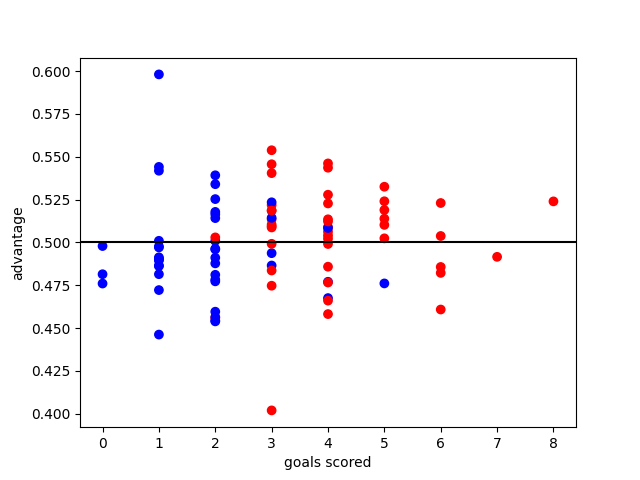

[Text(0.5, 0, 'goals scored'), Text(0, 0.5, 'advantage')]

In [57]:
%matplotlib notebook

fig, ax = plt.subplots(1)

ax.axhline(0.5, c='k')
ax.scatter(np.r_[p_goals_for_home, p_goals_for_away], np.r_[ha, aa], c=np.r_[p_wins_home, p_wins_away], cmap='bwr')
ax.set(xlabel='goals scored', ylabel='advantage')

In [58]:
all_goals = np.r_[p_goals_for_home, p_goals_for_away]
all_adv = np.r_[ha, aa]
all_ws = np.r_[p_wins_home, p_wins_away]
win_goals = all_goals[all_ws==1]
loss_goals = all_goals[all_ws==0]
win_adv = all_adv[all_ws==1]
loss_adv = all_adv[all_ws==0]

<IPython.core.display.Javascript object>


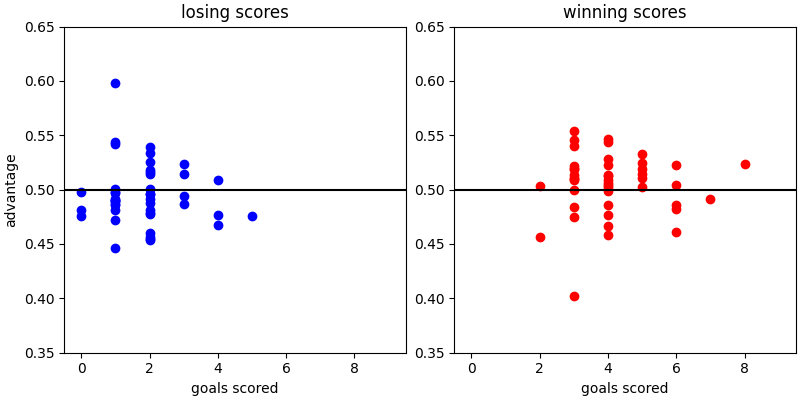

[Text(0.5, 0, 'goals scored'),
 Text(0.5, 1.0, 'winning scores'),
 (0.35, 0.65),
 (-0.5, 9.5)]

In [59]:
%matplotlib notebook

fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(8,4))

ax[0].axhline(0.5, c='k')
ax[0].scatter(loss_goals, loss_adv, c='b')
ax[1].axhline(0.5, c='k')
ax[1].scatter(win_goals, win_adv, c='r')

ax[0].set(xlabel='goals scored', ylabel='advantage', title='losing scores', ylim=(0.35,0.65), xlim=(-0.5, 9.5))
ax[1].set(xlabel='goals scored', title='winning scores', ylim=(0.35,0.65), xlim=(-0.5, 9.5))

<IPython.core.display.Javascript object>


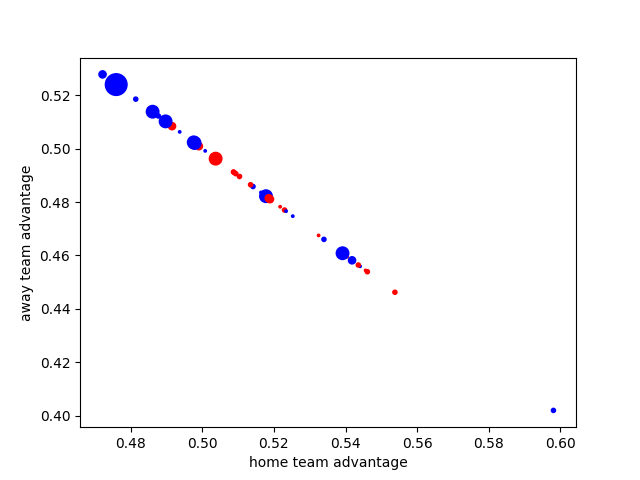

[Text(0.5, 0, 'home team advantage'), Text(0, 0.5, 'away team advantage')]

In [62]:
%matplotlib notebook

fig, ax = plt.subplots(1)

won_by = np.abs(p_goals_for_home - p_goals_for_away)
ax.scatter(ha, aa, s=np.power(3,won_by), c=p_wins_home, cmap='bwr')#, alpha=((1/won_by)/1.5))
ax.set(xlabel='home team advantage', ylabel='away team advantage')

# For scraping stats

In [10]:
home = np.zeros(len(gids), dtype='str')
away = np.zeros(len(gids), dtype='str')
xG_for_home = np.zeros(len(gids))
xG_for_away = np.zeros(len(gids))
goals_for_home = np.zeros(len(gids))
goals_for_away = np.zeros(len(gids))
blocked_for_home = np.zeros(len(gids))
blocked_for_away = np.zeros(len(gids))
f_home = np.zeros(len(gids))
f_away = np.zeros(len(gids))
pmins_drawn_home = np.zeros(len(gids))
pmins_drawn_away = np.zeros(len(gids))
gives_against_home = np.zeros(len(gids))
gives_against_away = np.zeros(len(gids))
takes_for_home = np.zeros(len(gids))
takes_for_away = np.zeros(len(gids))

In [11]:
strength_dict = {'0x5': 0, '5x6': 1, '5x2': 2, '4x4': 3, '5x3': 4, '5x1': 5, '4x3': 6, '4x6': 7, '6x6': 8, '5x0': 9, '4x5': 10, '6x1': 11, '5x7': 12, '5x4': 13, '1x5': 14, '2x5': 15, '3x5': 16, '2x3': 17, '0x0': 18, '1x1': 19, '1x0': 20, '8x5': 21, '-1x0': 22, '0x1': 23, '-1x-1': 24, '6x5': 25, '4x2': 26, '2x4': 27, '3x4': 28, '3x3': 29, '5x5': 30, 'crap':100, '6x4':101}
zone_dict = {'Off': 0, 'Neu': 1, 'Def': 2, 'crap':100}
shot_type_dict = {'TIP-IN': 1, 'DEFLECTED': 2, 'WRIST SHOT': 3, 'SLAP SHOT': 4, 'SNAP SHOT': 5, 'BACKHAND': 6, 'WRAP-AROUND': 7, 'crap':100}
prev_event_dict = {'MISS': 0, 'GIVE': 1, 'CHL': 2, 'SHOT': 3, 'GOAL': 4, 'STOP': 5, 'GEND': 6, 'FAC': 7, 'BLOCK': 8, 'HIT': 9, 'PENL': 10, 'TAKE': 11, 'DELPEN': 12, 'PSTR': 13, 'PEND': 14, 'EISTR': 15, 'crap':100}

In [21]:
# i = 1920
# gid = gids[i]
    
# home_team = [t for t, g in zip(pbp_table['Home_Team'], pbp_table['Game_Id']) if g==gid][0]
# away_team = [t for t, g in zip(pbp_table['Away_Team'], pbp_table['Game_Id']) if g==gid][0]
# home[i] = home_team
# away[i] = away_team

# events = [e for e, g in zip(pbp_table['Event'], pbp_table['Game_Id']) if g==gid]
# descriptions = [d for d, g in zip(pbp_table['Description'], pbp_table['Game_Id']) if g==gid]

# strength = ['crap' if s!=s else s for s, g in zip(pbp_table['Strength'], pbp_table['Game_Id']) if g==gid]
# xcoord = [0 if np.isnan(x)==True else x for x, g in zip(pbp_table['xC'], pbp_table['Game_Id']) if g==gid]
# ycoord = [0 if np.isnan(y)==True else y for y, g in zip(pbp_table['yC'], pbp_table['Game_Id']) if g==gid]
# per_time = [t for t, g in zip(pbp_table['Time_Elapsed'], pbp_table['Game_Id']) if g==gid]
# per = [p for p, g in zip(pbp_table['Period'], pbp_table['Game_Id']) if g==gid]
# secs = [s for s, g in zip(pbp_table['Seconds_Elapsed'], pbp_table['Game_Id']) if g==gid]
# zone = ['crap' if z!=z else z for z, g in zip(pbp_table['Ev_Zone'], pbp_table['Game_Id']) if g==gid]
# shot_type = ['crap' if t!=t else t for t, g in zip(pbp_table['Type'], pbp_table['Game_Id']) if g==gid]
# indices = range(len(pbp_table['Event']))
# prev_event = ['crap' if pbp_table['Event'].iloc[i-1]!=pbp_table['Event'].iloc[i-1] else pbp_table['Event'].iloc[i-1] for e, i, g in zip(pbp_table['Event'], indices, pbp_table['Game_Id']) if g==gid]
# prev_x = [0 if np.isnan(pbp_table['xC'].iloc[i-1])==True else pbp_table['xC'].iloc[i-1] for e, i, g in zip(pbp_table['Event'], indices, pbp_table['Game_Id']) if g==gid]
# prev_y = [0 if np.isnan(pbp_table['yC'].iloc[i-1])==True else pbp_table['yC'].iloc[i-1] for e, i, g in zip(pbp_table['Event'], indices, pbp_table['Game_Id']) if g==gid]

# since_last = [s-secs[l-1] if s>=secs[l-1] else -1 for s,l in zip(secs,range(len(secs)))]

# strength_nums = [strength_dict.get(x) for x in strength]
# zone_nums = [zone_dict.get(x) for x in zone]
# shot_type_nums = [shot_type_dict.get(x) for x in shot_type]
# prev_event_nums = [prev_event_dict.get(x) for x in prev_event]

# for j, e in enumerate(events):

#     if e == 'SHOT' or e == 'MISS':
#         if descriptions[j].startswith(home_team):
#             xG_for_home[i] += xG(strength_nums[j], xcoord[j], ycoord[j], per[j], secs[j], since_last[j],
#                                  zone_nums[j], shot_type_nums[j], prev_event_nums[j], prev_x[j], prev_y[j])
#         elif descriptions[j].startswith(away_team):
#             xG_for_away[i] += xG(strength_nums[j], xcoord[j], ycoord[j], per[j], secs[j], since_last[j],
#                                  zone_nums[j], shot_type_nums[j], prev_event_nums[j], prev_x[j], prev_y[j])

#     elif e == 'GOAL':
#         if descriptions[j].startswith(home_team):
#             goals_for_home[i] += 1
#             xG_for_home[i] += xG(strength_nums[j], xcoord[j], ycoord[j], per[j], secs[j], since_last[j],
#                                  zone_nums[j], shot_type_nums[j], prev_event_nums[j], prev_x[j], prev_y[j])
#         elif descriptions[j].startswith(away_team):
#             goals_for_away[i] += 1
#             xG_for_away[i] += xG(strength_nums[j], xcoord[j], ycoord[j], per[j], secs[j], since_last[j],
#                                  zone_nums[j], shot_type_nums[j], prev_event_nums[j], prev_x[j], prev_y[j])

#     elif e == 'BLOCK':
#         if descriptions[j].startswith(home_team):
#             blocked_for_home[i] += 1
#         elif descriptions[j].startswith(away_team):
#             blocked_for_away[i] += 1

#     elif e == 'PENL':
#         p_team = descriptions[j].split(' ')[0]
#         mins = int(descriptions[j].split(' min)')[0].split('(')[-1])
#         if p_team == home_team:
#             pmins_drawn_away[i] += mins
#         elif p_team == away_team:
#             pmins_drawn_home[i] += mins

#     elif e == 'FAC':
#         z, w, wt, l, lt = fo_parser(descriptions[j])
#         if wt == home_team:
#             f_home[i] += 1
#         elif wt == away_team:
#             f_away[i] += 1

#     elif e == 'GIVE':
#         if descriptions[j].startswith(home_team):
#             gives_against_away[i] += 1
#         elif descriptions[j].startswith(away_team):
#             gives_against_home[i] += 1

#     elif e == 'TAKE':
#         if descriptions[j].startswith(home_team):
#             takes_for_home[i] += 1
#         elif descriptions[j].startswith(away_team):
#             takes_for_away[i] += 1

In [12]:
for i, gid in tqdm(enumerate(gids)):
    
    home_team = [t for t, g in zip(pbp_table['Home_Team'], pbp_table['Game_Id']) if g==gid][0]
    away_team = [t for t, g in zip(pbp_table['Away_Team'], pbp_table['Game_Id']) if g==gid][0]
    home[i] = home_team
    away[i] = away_team

    events = [e for e, g in zip(pbp_table['Event'], pbp_table['Game_Id']) if g==gid]
    descriptions = [d for d, g in zip(pbp_table['Description'], pbp_table['Game_Id']) if g==gid]
    
    strength = ['crap' if s!=s else s for s, g in zip(pbp_table['Strength'], pbp_table['Game_Id']) if g==gid]
    xcoord = [0 if np.isnan(x)==True else x for x, g in zip(pbp_table['xC'], pbp_table['Game_Id']) if g==gid]
    ycoord = [0 if np.isnan(y)==True else y for y, g in zip(pbp_table['yC'], pbp_table['Game_Id']) if g==gid]
    per_time = [t for t, g in zip(pbp_table['Time_Elapsed'], pbp_table['Game_Id']) if g==gid]
    per = [p for p, g in zip(pbp_table['Period'], pbp_table['Game_Id']) if g==gid]
    secs = [s for s, g in zip(pbp_table['Seconds_Elapsed'], pbp_table['Game_Id']) if g==gid]
    zone = ['crap' if z!=z else z for z, g in zip(pbp_table['Ev_Zone'], pbp_table['Game_Id']) if g==gid]
    shot_type = ['crap' if t!=t else t for t, g in zip(pbp_table['Type'], pbp_table['Game_Id']) if g==gid]
    indices = range(len(pbp_table['Event']))
    prev_event = ['crap' if pbp_table['Event'].iloc[i-1]!=pbp_table['Event'].iloc[i-1] else pbp_table['Event'].iloc[i-1] for e, i, g in zip(pbp_table['Event'], indices, pbp_table['Game_Id']) if g==gid]
    prev_x = [0 if np.isnan(pbp_table['xC'].iloc[i-1])==True else pbp_table['xC'].iloc[i-1] for e, i, g in zip(pbp_table['Event'], indices, pbp_table['Game_Id']) if g==gid]
    prev_y = [0 if np.isnan(pbp_table['yC'].iloc[i-1])==True else pbp_table['yC'].iloc[i-1] for e, i, g in zip(pbp_table['Event'], indices, pbp_table['Game_Id']) if g==gid]

    since_last = [s-secs[l-1] if s>=secs[l-1] else -1 for s,l in zip(secs,range(len(secs)))]
    
    strength_nums = [strength_dict.get(x) for x in strength]
    zone_nums = [zone_dict.get(x) for x in zone]
    shot_type_nums = [shot_type_dict.get(x) for x in shot_type]
    prev_event_nums = [prev_event_dict.get(x) for x in prev_event]
    
    for j, e in enumerate(events):

        if e == 'SHOT' or e == 'MISS':
            if descriptions[j].startswith(home_team):
                xG_for_home[i] += xG(strength_nums[j], xcoord[j], ycoord[j], per[j], secs[j], since_last[j],
                                     zone_nums[j], shot_type_nums[j], prev_event_nums[j], prev_x[j], prev_y[j])
            elif descriptions[j].startswith(away_team):
                xG_for_away[i] += xG(strength_nums[j], xcoord[j], ycoord[j], per[j], secs[j], since_last[j],
                                     zone_nums[j], shot_type_nums[j], prev_event_nums[j], prev_x[j], prev_y[j])
                
        elif e == 'GOAL':
            if descriptions[j].startswith(home_team):
                goals_for_home[i] += 1
                xG_for_home[i] += xG(strength_nums[j], xcoord[j], ycoord[j], per[j], secs[j], since_last[j],
                                     zone_nums[j], shot_type_nums[j], prev_event_nums[j], prev_x[j], prev_y[j])
            elif descriptions[j].startswith(away_team):
                goals_for_away[i] += 1
                xG_for_away[i] += xG(strength_nums[j], xcoord[j], ycoord[j], per[j], secs[j], since_last[j],
                                     zone_nums[j], shot_type_nums[j], prev_event_nums[j], prev_x[j], prev_y[j])

        elif e == 'BLOCK':
            if descriptions[j].startswith(home_team):
                blocked_for_home[i] += 1
            elif descriptions[j].startswith(away_team):
                blocked_for_away[i] += 1

        elif e == 'PENL':
            p_team = descriptions[j].split(' ')[0]
            mins = int(descriptions[j].split(' min)')[0].split('(')[-1])
            if p_team == home_team:
                pmins_drawn_away[i] += mins
            elif p_team == away_team:
                pmins_drawn_home[i] += mins

        elif e == 'FAC':
            z, w, wt, l, lt = fo_parser(descriptions[j])
            if wt == home_team:
                f_home[i] += 1
            elif wt == away_team:
                f_away[i] += 1

        elif e == 'GIVE':
            if descriptions[j].startswith(home_team):
                gives_against_away[i] += 1
            elif descriptions[j].startswith(away_team):
                gives_against_home[i] += 1

        elif e == 'TAKE':
            if descriptions[j].startswith(home_team):
                takes_for_home[i] += 1
            elif descriptions[j].startswith(away_team):
                takes_for_away[i] += 1

4529it [4:28:37,  3.56s/it]


In [ ]:
# # DEBUGGER

# gid = gids[4712]
    
# home_team = [t for t, g in zip(pbp_table['Home_Team'], pbp_table['Game_Id']) if g==gid][0]
# away_team = [t for t, g in zip(pbp_table['Away_Team'], pbp_table['Game_Id']) if g==gid][0]
# home.append(home_team)
# away.append(away_team)

# events = [e for e, g in zip(pbp_table['Event'], pbp_table['Game_Id']) if g==gid]
# descriptions = [d for d, g in zip(pbp_table['Description'], pbp_table['Game_Id']) if g==gid]

# for j, e in enumerate(events):

#     if e == 'FAC':
#         z, w, wt, l, lt = fo_parser(descriptions[j])
#         print(z, w, wt, l, lt)
# #         if wt == home_team:
# #             f_home[i] += 1
# #         elif wt == away_team:
# #             f_away[i] += 1

In [6]:
# for i, d in enumerate(pbp_table.loc[(pbp_table['Game_Id']==20224)]['Description']):
#     if 'vs' in d:
#         print(d)

In [10]:
# save_pct_home = (sog_for_away - goals_for_away) / sog_for_away
# save_pct_away = (sog_for_home - goals_for_home) / sog_for_home

In [13]:
len(home)

4529

In [15]:
home

array(['C', 'N', 'A', ..., 'N', 'P', 'W'], dtype='<U1')

In [14]:
# write to csv for safekeeping
d = {'Home team':home, 'Away team':away, 
     'Goals for home':goals_for_home, 'Goals for away':goals_for_away, 
     'Blocked for home':blocked_for_home, 'Blocked for away':blocked_for_away, 
     'xG for home':xG_for_home, 'xG for away':xG_for_away,
     'FOW% home':f_home, 'FOW% away':f_away, 
     'Penalty minutes drawn home':pmins_drawn_home, 'Penalty minutes drawn away':pmins_drawn_away, 
     'Gives against home':gives_against_home, 'Gives against away':gives_against_away, 
     'Takeaways for home':takes_for_home, 'Takeaways for away':takes_for_away}
f = pd.DataFrame(d)
f.to_csv('full_stats.csv')